In [1]:
# 1. Install your library directly from PyPI!
!pip install spectralora

# 2. Unzip the dataset quietly (-q) and overwrite (-o) if it already exists
!unzip -o -q dataset_224x224.zip
print("✅ Library installed and dataset unzipped.")

✅ Library installed and dataset unzipped.


In [2]:
import os
import random
import shutil

source_folder = "dataset_224x224"
train_folder = "train_data"
test_folder = "test_data"

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Get all tif files
all_chips = [f for f in os.listdir(source_folder) if f.endswith('.tif')]
random.shuffle(all_chips)

# Split: 2 for testing, the rest for training
test_chips = all_chips[:2]
train_chips = all_chips[2:]

# Copy files to their new homes
for f in test_chips:
    shutil.copy(os.path.join(source_folder, f), os.path.join(test_folder, f))
for f in train_chips:
    shutil.copy(os.path.join(source_folder, f), os.path.join(train_folder, f))

print(f"✅ Data Split Complete!")
print(f"   Training Images: {len(train_chips)}")
print(f"   Testing Images:  {len(test_chips)}")

✅ Data Split Complete!
   Training Images: 11
   Testing Images:  2


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import rasterio
import numpy as np
import math
import os

from spectra_lora import (
    load_prithvi_model, inject_spectra_lora, SpectraConfig,
    get_spectral_fingerprint, SpectraLoRALayer
)

# --- 1. Dataset & Pseudo-Labeler ---
class RealSatelliteDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.folder_path, self.files[idx])
        with rasterio.open(path) as src:
            img = src.read().astype(np.float32) / 10000.0

        img_tensor = torch.from_numpy(img)

        # 4-Class Pseudo-Labels: 0=Barren, 1=Vegetation, 2=Water, 3=Urban
        blue, green, red = img_tensor[0], img_tensor[1], img_tensor[2]
        nir, swir1 = img_tensor[3], img_tensor[4]

        ndvi = (nir - red) / (nir + red + 1e-8)
        ndwi = (green - nir) / (green + nir + 1e-8)
        ndbi = (swir1 - nir) / (swir1 + nir + 1e-8)

        mask = torch.zeros((224, 224), dtype=torch.long)
        mask[ndvi > 0.25] = 1
        mask[ndwi > 0.15] = 2
        mask[(ndbi > 0.05) & (mask == 0)] = 3

        return img_tensor, mask

# --- 2. Decoder ---
class SimpleDecoder(nn.Module):
    def __init__(self, embed_dim=768, num_classes=4):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=16, mode='bilinear', align_corners=False),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = x[:, 1:, :]
        B, N, C = x.shape
        H, W = int(math.sqrt(N)), int(math.sqrt(N))
        x = x.transpose(1, 2).reshape(B, C, H, W)
        return self.decode(x)

# --- 3. Context Bridge ---
class SpectraContext:
    current_z = None

def patch_model_for_context(model):
    for module in model.modules():
        if isinstance(module, SpectraLoRALayer):
            original_forward = module.forward
            def patched_forward(x):
                return original_forward(x, SpectraContext.current_z)
            module.forward = patched_forward
    return model

# --- 4. Training Engine ---
config = SpectraConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Starting Training on {device}...")

encoder = load_prithvi_model()
encoder = inject_spectra_lora(encoder)
encoder = patch_model_for_context(encoder)
decoder = SimpleDecoder(num_classes=4)
model = nn.Sequential(encoder, decoder).to(device)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params, lr=3e-4)
criterion = nn.CrossEntropyLoss()

dataset = RealSatelliteDataset("train_data")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

model.train()
num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        with torch.no_grad():
            SpectraContext.current_z = get_spectral_fingerprint(images, config.BAND_MAP)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"🌍 Epoch {epoch+1}/{num_epochs} Complete. Avg Loss: {epoch_loss/len(dataloader):.4f}")

torch.save(model.state_dict(), "colab_spectra_lora_weights.pth")
print("💾 Model weights saved to 'colab_spectra_lora_weights.pth'")

🚀 Starting Training on cuda...
🌍 SpectraLoRA: Downloading Prithvi weights from ibm-nasa-geospatial/Prithvi-EO-1.0-100M...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Prithvi_100M.pt:   0%|          | 0.00/454M [00:00<?, ?B/s]

🏗️ Constructing Model Architecture (Local PrithviViT)...
⚖️ Loading Weights...
✅ Model Loaded. (Ignored decoder weights: True)
✨ SpectraLoRA: Beginning surgery on the model...
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
   -> 💉 Injecting LoRA into QKV:  768 -> 2304
✅ Surgery Complete. SpectraLoRA layers injected: 0
🌍 Epoch 1/20 Complete. Avg Loss: 1.7055
🌍 Epoch 2/20 Complete. Avg Loss: 1.0536
🌍 Epoch 3/20 Complete. Avg Loss: 0.8861
🌍 Epoch 4/20 Complete. Avg Loss: 0.8447
🌍 Epoch 5/20 Complete. Avg Loss: 0.8467
🌍 Epoch 6/20 Complete

⚖️ Loading Trained Weights for Testing...


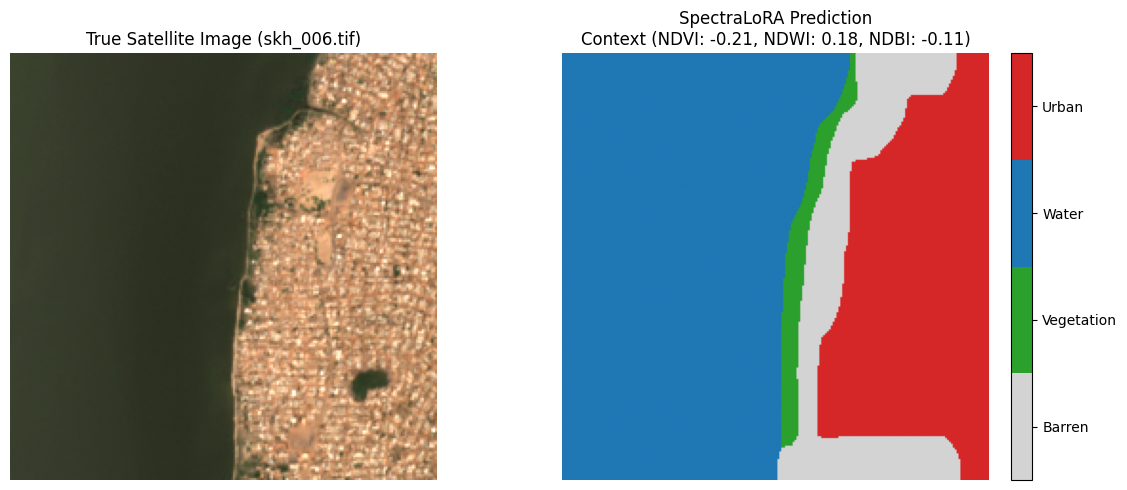

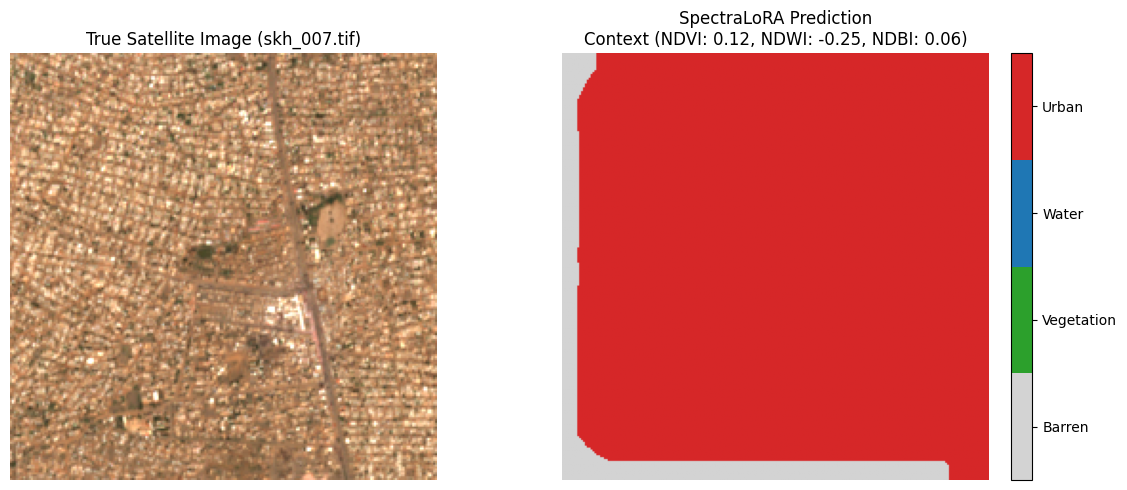

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def load_chip(filepath):
    with rasterio.open(filepath) as src:
        raw_img = src.read().astype(np.float32) / 10000.0
    tensor_img = torch.from_numpy(raw_img).unsqueeze(0).to(device)
    rgb = np.stack([raw_img[2], raw_img[1], raw_img[0]], axis=-1)
    rgb = np.clip(rgb * 3.0, 0, 1)
    return tensor_img, rgb

print("⚖️ Loading Trained Weights for Testing...")
model.load_state_dict(torch.load("colab_spectra_lora_weights.pth"))
model.eval()

cmap = ListedColormap(['#d3d3d3', '#2ca02c', '#1f77b4', '#d62728'])
test_files = [f for f in os.listdir("test_data") if f.endswith('.tif')]

for filename in test_files:
    chip_path = os.path.join("test_data", filename)
    tensor_img, rgb_img = load_chip(chip_path)

    with torch.no_grad():
        z = get_spectral_fingerprint(tensor_img, config.BAND_MAP)
        SpectraContext.current_z = z
        logits = model(tensor_img)
        prediction = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.imshow(rgb_img)
    ax1.set_title(f"True Satellite Image ({filename})")
    ax1.axis('off')

    im = ax2.imshow(prediction, cmap=cmap, vmin=0, vmax=3)
    ax2.set_title(f"SpectraLoRA Prediction\nContext (NDVI: {z[0,0]:.2f}, NDWI: {z[0,2]:.2f}, NDBI: {z[0,3]:.2f})")
    ax2.axis('off')

    cbar = plt.colorbar(im, ax=ax2, ticks=[0.375, 1.125, 1.875, 2.625], fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(['Barren', 'Vegetation', 'Water', 'Urban'])

    plt.tight_layout()
    plt.show()